In [3]:
import math
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [4]:
def f(x):
    return 3*x**2 - 4*x + 5

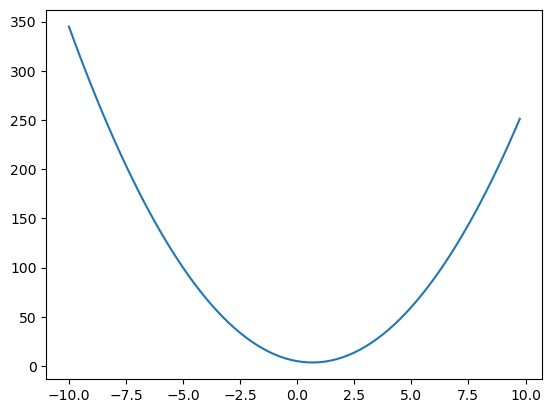

In [5]:
xs = np.arange(-10,10,0.25)
ys = f(xs)
plt.plot(xs,ys)

In [57]:
class Value:
    
    def __init__(self, data, _children=(), _op="",label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self.label = label
        self._op = _op
        
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self,other):
        other = other if isinstance(other,Value) else Value(other)
        out = Value(self.data + other.data, (self,other), '+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self,other):
        return self + (-other)
    
    def __mul__(self,other):
        other = other if isinstance(other,Value) else Value(other)
        out = Value(self.data * other.data, (self,other), '*')
        
        def _backward():
            self.grad += (other.data)*(out.grad)
            other.grad += (self.data)*(out.grad)
        out._backward = _backward    
        return out
    
    def __rmul__(self, other): # other * self
        return self * other
    
    def __truediv__(self, other):
        return self * other**-1
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/floadt for now"
        out = Value(self.data**other,(self,), f'**{other}')
        
        def _backward():
            self.grad = other * (self.data ** (other - 1))*out.grad
        out._backward = _backward
        return out 
                    
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh', 'o')
        
        def _backward():
            self.grad += (1 - t**2)*(out.grad)
        out._backward = _backward
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        
        return out
    
    def backward(self):
        
        # Topological Sort to know the order of execution
        self.grad = 1
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
                   
        for node in reversed(topo):
            node._backward()
                
    
    
a = Value(2.0, label='a')
b = Value(3.0,label='b')
c = Value(10.0, label='c')
e = a*b; e.label='e'
f = Value(-2.0, label='f')
d = e + c; d.label = 'd'
L = f*d ; L.label = 'L'    

In [15]:
d._prev

{Value(data=-6.0), Value(data=10.0)}

In [16]:
d._op

'+'

In [17]:
from graphviz import Digraph

def trace(root):
    #build a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child,v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    
    dot = Digraph(format='svg', graph_attr={'rankdir' : 'LR'}) # LR = Left to right
    
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular {'record'} node for it
        dot.node(name=uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    return dot

In [29]:
L.backward()

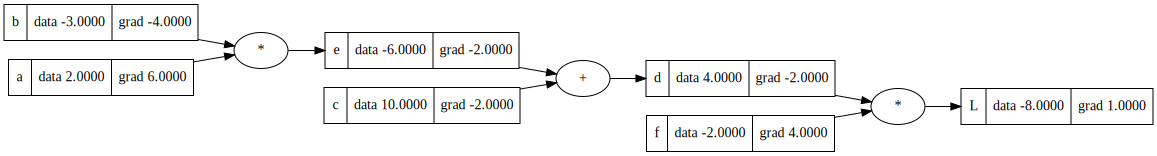

In [30]:
draw_dot(L)

In [19]:
def lol():
    
    h = 0.0001
    
    a = Value(2.0, label='a')
    b = Value(-3.0,label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label='e'
    f = Value(-2.0, label='f')
    d = e + c; d.label = 'd'
    L = f*d
    L1 = L.data
    
    a = Value(2.0 + h, label='a')
    b = Value(-3.0,label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label='e'
    f = Value(-2.0, label='f')
    d = e + c; d.label = 'd'
    L = f*d
    L2 = L.data
    
    print((L2 - L1)/h)
lol()

6.000000000021544


In [61]:
# Implementation of backprop on neuron 

# inputs 
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights 
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of neuron
b = Value(6.8813735870195432, label='b')

# x1w1 + x2w2 + b
x1w1 = x1*w1 ; x1w1.label = 'x1w1'
x2w2 = x2*w2 ; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2 ; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b ; n.label = 'n'
o = n.tanh()


#------------- instead of tanh()
# e = (2*n).exp()
# o = (e - 1)/(e + 1)
#-----------
o.label = 'o'
o.backward()

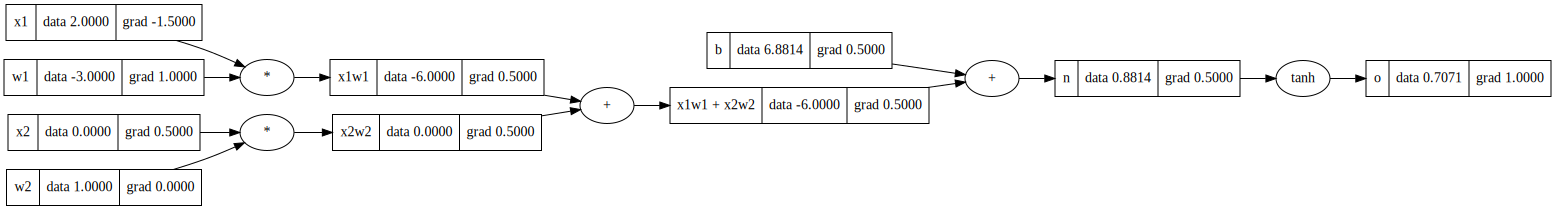

In [62]:
draw_dot(o)

In [22]:
o.grad = 1.0  # do/do

In [23]:
# o = tan(n)
# do/dn = 1 - tan(n)**2

n.grad = 1 - o.data**2

# + distrubute the grade 
x1w1x2w2.grad = n.grad
b.grad = n.grad
x1w1.grad = x1w1x2w2.grad
x2w2.grad = x1w1x2w2.grad


# do/dw1 = (dx1w1/dw1)*(do/dx1w1)

w1.grad = x1.data * x1w1.grad
w2.grad = x2.data * x2w2.grad
x1.grad = w1.data * x1w1.grad
x2.grad = w2.data * x2w2.grad

In [24]:

o.backward()


In [25]:
n._backward()
x1w1x2w2._backward()
x1w1._backward()
x2w2._backward()

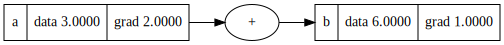

In [26]:
#bug 
a = Value(3.0,label ='a')
b = a + a ; b.label = 'b'

b.backward()
draw_dot(b) # db/da should be 2 

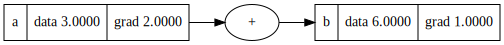

In [27]:
#bug : Solution accumlate the grads
a = Value(3.0,label ='a')
b = a + a ; b.label = 'b'

b.backward()
draw_dot(b) # db/da should be 2 

Value(data=6.0)

In [45]:
a.exp()

Value(data=7.38905609893065)

In [58]:
a - b

Value(data=-1.0)

In [63]:
# Implementation of the same in pytorch

import torch

In [66]:
x1 = torch.Tensor([2.0]).double() ;                 x1.requires_grad = True
x2 = torch.Tensor([0.0]).double() ;                 x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double();                 w1.requires_grad = True
w2 = torch.Tensor([1.0]).double() ;                 w2.requires_grad = True
b = torch.Tensor([6.8813735878195432]).double() ;   b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print("-------------")
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
-------------
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [82]:
import random 

In [89]:

class Neuron:
    
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
        
    def __call__(self, x): # n(x)
        # w * x + b
        act = sum((wi*xi for wi, xi in zip(self.w,x)), self.b)
        out = act.tanh()
        return out
    
class Layer:
    
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
        
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs  

class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
                       
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
x = [2.0, 3.0, -1.0]
n = MLP(3, [4,4,1])
n(x)

Value(data=-0.9961986822377604)

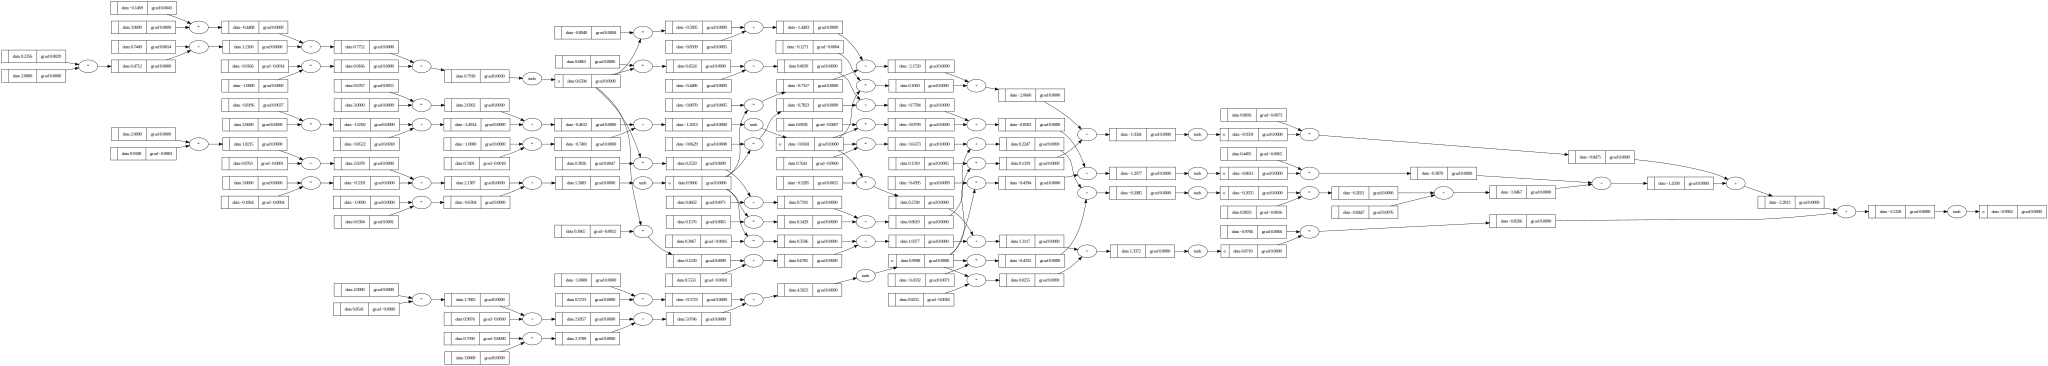

In [94]:

draw_dot(n(x))